# CSE251B Project Milestone Starter File

## Step 1: Import Dependencies:

In [1]:
!pip install torch-geometric

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn.functional as F
from transformers import MambaModel, MambaConfig
from typing import Optional, Tuple, Dict
import tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.7 MB/s eta 0:00:00


## Step 2: Load the Dataset

#### You need to describe in your own words what the dataset is about, and use mathematical language and formulate your prediction task on the submitted PDF file for Question 1 Problem A.

#### Here we are loading the dataset from the local directory. And answer Question 1 Problem B

In [2]:
from google.colab import drive
drive.mount('/content/drive')
train_npz = np.load('/content/drive/My Drive/251B_data/train.npz')
test_npz = np.load('/content/drive/My Drive/251B_data/test_input.npz')
train_data = train_npz['data']
test_data = test_npz['data']

Mounted at /content/drive


In [3]:
print(train_data.shape, test_data.shape)

# Split once for later use
X_train = train_data[..., :50, :]
Y_train = train_data[:, 0, 50:, :2]

(10000, 50, 110, 6) (2100, 50, 50, 6)


In [4]:
xy_in = train_data[:, :, :50, :2].reshape(-1, 2)
# only find the x, y != 0
xy_in_not_0 = xy_in[(xy_in[:, 0] != 0) & (xy_in[:, 1] != 0)]

#### Try to play around with dataset for training and testing, make exploratory analysis on the dataset for bonus points(up to 2)

## Step 3: Setting up the Training and Testing

### Example Code:

In [8]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torch_geometric.data import Data

class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: shape (N, 50, 110, 6)
        scale: normalization factor
        augment: whether to apply random horizontal flipping
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx].copy()  # *** CRITICAL: Make a copy! ***

        # === Rotate so agent 0 has heading 0 at t=49 ===
        ego_heading = scene[0, 49, 4]
        cos_theta = np.cos(-ego_heading)
        sin_theta = np.sin(-ego_heading)
        R = np.array([[cos_theta, -sin_theta],
                      [sin_theta,  cos_theta]], dtype=np.float32)

        scene[..., 0:2] = scene[..., 0:2] @ R.T  # Rotate positions
        scene[..., 2:4] = scene[..., 2:4] @ R.T  # Rotate velocities
        scene[..., 4] = scene[..., 4] - ego_heading  # Normalize heading

        # === Get history and future ===
        hist = scene[:, :50, :].copy()  # (50, 50, 6)
        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)

        # === Random horizontal flip (only during training) ===
        if self.augment:
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1     # Flip x position
                hist[..., 2] *= -1     # Flip x velocity
                future[:, 0] *= -1     # Flip future x

        # === Translate to origin (agent 0 at t=49) ===
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        future = future - origin

        # === Normalize by scale ===
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        return Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future,
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )


class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 50, 6) for test set with historical trajectory only
        scale: Normalization factor
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx].copy()  # *** CRITICAL: Make a copy! ***

        # === Rotate so agent 0 has heading 0 at t=49 ===
        ego_heading = scene[0, 49, 4]
        cos_theta = np.cos(-ego_heading)
        sin_theta = np.sin(-ego_heading)
        R = np.array([[cos_theta, -sin_theta],
                      [sin_theta,  cos_theta]], dtype=np.float32)

        # Apply rotation (same as training: @ R.T)
        scene[..., 0:2] = scene[..., 0:2] @ R.T  # Rotate positions
        scene[..., 2:4] = scene[..., 2:4] @ R.T  # Rotate velocities
        scene[..., 4] = scene[..., 4] - ego_heading  # Normalize heading

        # === Get history (only historical data available for test) ===
        hist = scene.copy()  # (50, 50, 6)

        # === Translate to origin (agent 0 at t=49) - SAME AS TRAINING ===
        origin = hist[0, 49, :2].copy()  # Store origin AFTER rotation, just like training
        hist[..., :2] = hist[..., :2] - origin

        # === Normalize by scale ===
        hist[..., :4] = hist[..., :4] / self.scale

        return Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
            rotation=torch.tensor(R, dtype=torch.float32)  # Store R for inverse transform
        )

#### Answer Question related to Your Computational Platform and GPU for Question 2 Problem A

In [22]:
torch.manual_seed(251)
np.random.seed(42)

scale = 10.0

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

#train_data_shuffled = np.random.permutation(train_data)

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
#train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=False)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x))
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x))

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using CUDA GPU


#### Your Model for Question 2 Problem B (Include your model architecture pictures and also can use some mathmatical equations to explain your model in your report)

#### This Model will be covered during Week 6 Lecture (If you don't understand it for now, don't worry, we will cover it in the lecture, or you can ask in the office hours)

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImprovedSocialAttention(nn.Module):
    def __init__(self, ego_dim, other_dim, radius=40.0, heads=8):
        super().__init__()
        self.radius = radius
        self.heads = heads
        self.head_dim = other_dim // heads

        # Multi-head projections
        self.q_proj = nn.Linear(ego_dim, other_dim)
        self.k_proj = nn.Linear(other_dim + 5, other_dim)
        self.v_proj = nn.Linear(other_dim + 5, other_dim)
        self.out = nn.Linear(other_dim, other_dim)

        # Learnable positional encoding for relative positions
        self.pos_encoding = nn.Sequential(
            nn.Linear(5, other_dim // 4),
            nn.ReLU(),
            nn.Linear(other_dim // 4, other_dim)
        )

        self.dropout = nn.Dropout(0.1)

    def forward(self, ego_h, other_h, rel_pos, rel_vel):
        """
        ego_h   : [B, emb]             (query from ego LSTM)
        other_h : [B, A-1, emb]        (other-agent encodings)
        rel_pos : [B, A-1, 3]          (dx, dy, dist)
        rel_vel : [B, A-1, 2]          (dvx, dvy)
        """
        B, N, _ = other_h.shape

        distances = rel_pos[..., 2]
        mask = distances <= self.radius

        if mask.sum() == 0:
            return torch.zeros_like(other_h[:, 0])

        rel_features = torch.cat([rel_pos, rel_vel], dim=-1)

        # Enhanced K, V with positional encoding
        pos_enc = self.pos_encoding(rel_features)
        kv_input = other_h + pos_enc  # Residual connection with position

        q = self.q_proj(ego_h).view(B, 1, self.heads, self.head_dim)
        k = self.k_proj(torch.cat([kv_input, rel_features], dim=-1)).view(B, N, self.heads, self.head_dim)
        v = self.v_proj(torch.cat([kv_input, rel_features], dim=-1)).view(B, N, self.heads, self.head_dim)

        # Scaled dot-product attention with improved masking
        attn = torch.einsum('bqhd,bnhd->bnhq', q, k) / (self.head_dim ** 0.5)

        # Distance-aware attention weighting
        distance_weight = torch.exp(-distances / (self.radius / 3)).unsqueeze(-1).unsqueeze(-1)
        attn = attn * distance_weight

        attn = attn.masked_fill(~mask.unsqueeze(-1).unsqueeze(-1), -1e9)
        attn = F.softmax(attn, dim=1)
        attn = self.dropout(attn)

        ctx = torch.einsum('bnhq,bnhd->bqhd', attn, v).flatten(2)
        return self.out(ctx.squeeze(1))

class ImprovedLSTMParametricTrajectoryFeatures(nn.Module):
    def __init__(self,
                 input_dim=9,
                 emb_dim=128,
                 hidden_dim=256,
                 lstm_layers=2,
                 degree=3,
                 social_heads=8,
                 radius=35.0,
                 other_rnn_dim=256):
        super().__init__()
        self.degree = degree
        self.hidden_dim = hidden_dim

        # Enhanced ego network with bidirectional LSTM
        self.emb = nn.Linear(input_dim, emb_dim)
        self.norm = nn.LayerNorm(emb_dim)
        self.ego_lstm = nn.LSTM(emb_dim, hidden_dim,
                                batch_first=True, num_layers=lstm_layers,
                                bidirectional=True, dropout=0.1)

        # Project bidirectional output back to hidden_dim
        self.ego_proj = nn.Linear(hidden_dim * 2, hidden_dim)

        # Enhanced other-agent encoder
        self.other_emb = nn.Linear(input_dim, other_rnn_dim)
        self.other_norm = nn.LayerNorm(other_rnn_dim)
        self.other_gru = nn.GRU(other_rnn_dim, other_rnn_dim,
                                batch_first=True, num_layers=2, dropout=0.1)

        # Improved social attention
        self.social_attn = ImprovedSocialAttention(
            ego_dim=hidden_dim, other_dim=other_rnn_dim,
            radius=radius, heads=social_heads
        )

        # Enhanced fusion network
        self.fuse = nn.Sequential(
            nn.Linear(hidden_dim + other_rnn_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )

        # Separate heads for x and y coefficients
        self.fc_x = nn.Linear(hidden_dim, degree + 1)
        self.fc_y = nn.Linear(hidden_dim, degree + 1)

    def enhanced_featurize(self, raw):
        """Enhanced feature engineering"""
        xp, yp, vx, vy, hd = (raw[..., i] for i in range(5))

        # Basic features
        cos_h = torch.cos(hd)
        sin_h = torch.sin(hd)
        speed = torch.sqrt(vx**2 + vy**2 + 1e-6)

        # Enhanced features
        # Acceleration (finite difference)
        ax = torch.cat([torch.zeros_like(vx[..., :1]), vx[..., 1:] - vx[..., :-1]], dim=-1)
        ay = torch.cat([torch.zeros_like(vy[..., :1]), vy[..., 1:] - vy[..., :-1]], dim=-1)

        # Angular velocity (handle angle wrapping manually)
        hd_diff = hd[..., 1:] - hd[..., :-1]
        # Handle angle wrapping: if difference > pi, subtract 2*pi; if < -pi, add 2*pi
        hd_diff = torch.where(hd_diff > torch.pi, hd_diff - 2*torch.pi, hd_diff)
        hd_diff = torch.where(hd_diff < -torch.pi, hd_diff + 2*torch.pi, hd_diff)
        angular_vel = torch.cat([torch.zeros_like(hd[..., :1]), hd_diff], dim=-1)

        return torch.stack([xp, yp, vx, vy, cos_h, sin_h, speed, ax, ay], dim=-1)

    def forward(self, data):
        x = data.x.reshape(-1, 50, 50, 6)
        ego_raw = x[:, 0]                    # [B, 50, 6]
        others_raw = x[:, 1:]                # [B, A-1, 50, 6]
        B, A1, T, _ = others_raw.shape

        # Enhanced feature engineering
        ego_feat = self.enhanced_featurize(ego_raw)         # [B, 50, 9]
        others_feat = self.enhanced_featurize(
            others_raw.reshape(B*A1, T, 6)
        ).reshape(B, A1, T, -1)                             # [B, A-1, 50, 9]

        # Encode ego with bidirectional LSTM
        ego_emb = self.norm(self.emb(ego_feat))
        ego_out, (ego_h, _) = self.ego_lstm(ego_emb)

        # Use final hidden state from both directions
        ego_h = self.ego_proj(ego_h[-2:].transpose(0, 1).flatten(1))  # [B, hidden_dim]

        # Enhanced other-agent encoding
        other_emb = self.other_norm(self.other_emb(others_feat.view(B*A1, T, -1)))
        _, other_h = self.other_gru(other_emb)
        other_h = other_h[-1].view(B, A1, -1)               # [B, A-1, other_rnn_dim]

        # Enhanced relative features
        ego_last = ego_feat[:, -1, :2].unsqueeze(1)         # [B, 1, 2]
        other_last = others_feat[:, :, -1, :2]              # [B, A-1, 2]
        rel_pos_vec = other_last - ego_last                 # [B, A-1, 2]
        dist = torch.norm(rel_pos_vec, dim=-1, keepdim=True)
        rel_pos = torch.cat([rel_pos_vec, dist], dim=-1)   # [B, A-1, 3]

        # Relative velocity
        ego_vel = ego_feat[:, -1, 2:4].unsqueeze(1)         # [B, 1, 2]
        other_vel = others_feat[:, :, -1, 2:4]              # [B, A-1, 2]
        rel_vel = other_vel - ego_vel                       # [B, A-1, 2]

        # Social attention with relative velocity
        social_ctx = self.social_attn(ego_h, other_h, rel_pos, rel_vel)

        # Enhanced fusion
        fused = self.fuse(torch.cat([ego_h, social_ctx], dim=-1))

        # Separate prediction heads
        a_coeffs = self.fc_x(fused)  # x coefficients
        b_coeffs = self.fc_y(fused)  # y coefficients

        # Enhanced polynomial basis with Chebyshev polynomials for better numerical stability
        t = torch.linspace(0, 1, 60, device=x.device)

        # Use orthogonal polynomial basis for better conditioning
        basis_funcs = []
        for i in range(self.degree + 1):
            if i == 0:
                basis_funcs.append(torch.ones_like(t))
            elif i == 1:
                basis_funcs.append(t)
            else:
                # Legendre polynomial recurrence for better numerical properties
                basis_funcs.append(((2*i-1) * t * basis_funcs[-1] - (i-1) * basis_funcs[-2]) / i)

        t_poly = torch.stack(basis_funcs, -1)               # [60, degree+1]
        t_poly = t_poly.expand(B, -1, -1)                   # [B, 60, degree+1]

        # Generate predictions
        x_pred = torch.bmm(t_poly, a_coeffs.unsqueeze(-1)).squeeze(-1)
        y_pred = torch.bmm(t_poly, b_coeffs.unsqueeze(-1)).squeeze(-1)

        # Add residual connection from last position
        last_pos = ego_feat[:, -1, :2]
        x_pred += last_pos[:, 0].unsqueeze(-1)
        y_pred += last_pos[:, 1].unsqueeze(-1)

        return torch.stack([x_pred, y_pred], dim=-1)        # [B, 60, 2]


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EgoOnlyLSTMParametricTrajectoryFeatures(nn.Module):
    def __init__(self,
                 input_dim=9,
                 emb_dim=128,
                 hidden_dim=256,
                 lstm_layers=2,
                 degree=3):
        super().__init__()
        self.degree = degree
        self.hidden_dim = hidden_dim

        # Embedding and normalization
        self.emb = nn.Linear(input_dim, emb_dim)
        self.norm = nn.LayerNorm(emb_dim)

        # Bidirectional LSTM for ego features
        self.ego_lstm = nn.LSTM(
            emb_dim, hidden_dim,
            batch_first=True, num_layers=lstm_layers,
            bidirectional=True, dropout=0.1
        )

        # Project bi-LSTM output
        self.ego_proj = nn.Linear(hidden_dim * 2, hidden_dim)

        # Deep feedforward network (analogous to fusion)
        self.deep_block = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )

        # Separate heads for x and y coefficients
        self.fc_x = nn.Linear(hidden_dim, degree + 1)
        self.fc_y = nn.Linear(hidden_dim, degree + 1)

    def enhanced_featurize(self, raw):
        xp, yp, vx, vy, hd = (raw[..., i] for i in range(5))

        cos_h = torch.cos(hd)
        sin_h = torch.sin(hd)
        speed = torch.sqrt(vx**2 + vy**2 + 1e-6)

        ax = torch.cat([torch.zeros_like(vx[..., :1]), vx[..., 1:] - vx[..., :-1]], dim=-1)
        ay = torch.cat([torch.zeros_like(vy[..., :1]), vy[..., 1:] - vy[..., :-1]], dim=-1)

        hd_diff = hd[..., 1:] - hd[..., :-1]
        hd_diff = torch.where(hd_diff > torch.pi, hd_diff - 2*torch.pi, hd_diff)
        hd_diff = torch.where(hd_diff < -torch.pi, hd_diff + 2*torch.pi, hd_diff)
        angular_vel = torch.cat([torch.zeros_like(hd[..., :1]), hd_diff], dim=-1)

        return torch.stack([xp, yp, vx, vy, cos_h, sin_h, speed, ax, ay], dim=-1)

    def forward(self, data):
        x = data.x.reshape(-1, 50, 50, 6)
        ego_raw = x[:, 0]  # [B, 50, 6]

        # Feature engineering
        ego_feat = self.enhanced_featurize(ego_raw)  # [B, 50, 9]

        # Embedding and normalization
        ego_emb = self.norm(self.emb(ego_feat))

        # Encode with bi-LSTM
        ego_out, (ego_h, _) = self.ego_lstm(ego_emb)

        # Concatenate final hidden states
        ego_h = self.ego_proj(ego_h[-2:].transpose(0, 1).flatten(1))  # [B, hidden_dim]

        # Deep block
        deep_out = self.deep_block(ego_h)  # [B, hidden_dim]

        # Coefficient prediction
        a_coeffs = self.fc_x(deep_out)
        b_coeffs = self.fc_y(deep_out)

        # Generate polynomial basis (Legendre)
        t = torch.linspace(0, 1, 60, device=x.device)
        basis_funcs = []
        for i in range(self.degree + 1):
            if i == 0:
                basis_funcs.append(torch.ones_like(t))
            elif i == 1:
                basis_funcs.append(t)
            else:
                basis_funcs.append(((2*i-1)*t*basis_funcs[-1] - (i-1)*basis_funcs[-2])/i)
        t_poly = torch.stack(basis_funcs, -1).expand(ego_h.shape[0], -1, -1)  # [B, 60, degree+1]

        # Generate predictions
        x_pred = torch.bmm(t_poly, a_coeffs.unsqueeze(-1)).squeeze(-1)
        y_pred = torch.bmm(t_poly, b_coeffs.unsqueeze(-1)).squeeze(-1)

        return torch.stack([x_pred, y_pred], dim=-1)  # [B, 60, 2]


In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImprovedSocialAttention(nn.Module):
    def __init__(self, ego_dim, other_dim, radius=40.0, heads=8):
        super().__init__()
        self.radius = radius
        self.heads = heads
        self.head_dim = other_dim // heads

        # Multi-head projections
        self.q_proj = nn.Linear(ego_dim, other_dim)
        self.k_proj = nn.Linear(other_dim + 5, other_dim)  # Added relative velocity
        self.v_proj = nn.Linear(other_dim + 5, other_dim)
        self.out = nn.Linear(other_dim, other_dim)

        # Learnable positional encoding for relative positions
        self.pos_encoding = nn.Sequential(
            nn.Linear(5, other_dim // 4),
            nn.ReLU(),
            nn.Linear(other_dim // 4, other_dim)
        )

        self.dropout = nn.Dropout(0.1)

    def forward(self, ego_h, other_h, rel_pos, rel_vel):
        """
        ego_h   : [B, emb]             (query from ego LSTM)
        other_h : [B, A-1, emb]        (other-agent encodings)
        rel_pos : [B, A-1, 3]          (dx, dy, dist)
        rel_vel : [B, A-1, 2]          (dvx, dvy)
        """
        B, N, _ = other_h.shape

        # Enhanced distance-based masking with soft falloff
        distances = rel_pos[..., 2]
        mask = distances <= self.radius

        if mask.sum() == 0:
            return torch.zeros_like(other_h[:, 0])  # Return zero context

        # Combine relative position and velocity
        rel_features = torch.cat([rel_pos, rel_vel], dim=-1)  # [B, N, 5]

        # Enhanced K, V with positional encoding
        pos_enc = self.pos_encoding(rel_features)
        kv_input = other_h + pos_enc  # Residual connection with position

        q = self.q_proj(ego_h).view(B, 1, self.heads, self.head_dim)
        k = self.k_proj(torch.cat([kv_input, rel_features], dim=-1)).view(B, N, self.heads, self.head_dim)
        v = self.v_proj(torch.cat([kv_input, rel_features], dim=-1)).view(B, N, self.heads, self.head_dim)

        # Scaled dot-product attention with improved masking
        attn = torch.einsum('bqhd,bnhd->bnhq', q, k) / (self.head_dim ** 0.5)

        # Distance-aware attention weighting
        distance_weight = torch.exp(-distances / (self.radius / 3)).unsqueeze(-1).unsqueeze(-1)
        attn = attn * distance_weight

        attn = attn.masked_fill(~mask.unsqueeze(-1).unsqueeze(-1), -1e9)
        attn = F.softmax(attn, dim=1)
        attn = self.dropout(attn)

        ctx = torch.einsum('bnhq,bnhd->bqhd', attn, v).flatten(2)
        return self.out(ctx.squeeze(1))

class NoPolynomialLSTMParametricTrajectoryFeatures(nn.Module):
    def __init__(self,
                 input_dim=9,
                 emb_dim=128,
                 hidden_dim=256,
                 lstm_layers=2,
                 degree=3,
                 social_heads=8,
                 radius=35.0,
                 other_rnn_dim=256):
        super().__init__()
        self.degree = degree
        self.hidden_dim = hidden_dim

        # Enhanced ego network with bidirectional LSTM
        self.emb = nn.Linear(input_dim, emb_dim)
        self.norm = nn.LayerNorm(emb_dim)
        self.ego_lstm = nn.LSTM(emb_dim, hidden_dim,
                                batch_first=True, num_layers=lstm_layers,
                                bidirectional=True, dropout=0.1)

        # Project bidirectional output back to hidden_dim
        self.ego_proj = nn.Linear(hidden_dim * 2, hidden_dim)

        # Enhanced other-agent encoder
        self.other_emb = nn.Linear(input_dim, other_rnn_dim)
        self.other_norm = nn.LayerNorm(other_rnn_dim)
        self.other_gru = nn.GRU(other_rnn_dim, other_rnn_dim,
                                batch_first=True, num_layers=2, dropout=0.1)

        # Improved social attention
        self.social_attn = ImprovedSocialAttention(
            ego_dim=hidden_dim, other_dim=other_rnn_dim,
            radius=radius, heads=social_heads
        )

        # Enhanced fusion network
        self.fuse = nn.Sequential(
            nn.Linear(hidden_dim + other_rnn_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )

        # # Separate heads for x and y coefficients
        # self.fc_x = nn.Linear(hidden_dim, degree + 1)
        # self.fc_y = nn.Linear(hidden_dim, degree + 1)
        self.output_fc = nn.Linear(hidden_dim, 60*2)

    def enhanced_featurize(self, raw):
        """Enhanced feature engineering"""
        xp, yp, vx, vy, hd = (raw[..., i] for i in range(5))

        # Basic features
        cos_h = torch.cos(hd)
        sin_h = torch.sin(hd)
        speed = torch.sqrt(vx**2 + vy**2 + 1e-6)

        # Enhanced features
        # Acceleration (finite difference)
        ax = torch.cat([torch.zeros_like(vx[..., :1]), vx[..., 1:] - vx[..., :-1]], dim=-1)
        ay = torch.cat([torch.zeros_like(vy[..., :1]), vy[..., 1:] - vy[..., :-1]], dim=-1)

        # Angular velocity (handle angle wrapping manually)
        hd_diff = hd[..., 1:] - hd[..., :-1]
        # Handle angle wrapping: if difference > pi, subtract 2*pi; if < -pi, add 2*pi
        hd_diff = torch.where(hd_diff > torch.pi, hd_diff - 2*torch.pi, hd_diff)
        hd_diff = torch.where(hd_diff < -torch.pi, hd_diff + 2*torch.pi, hd_diff)
        angular_vel = torch.cat([torch.zeros_like(hd[..., :1]), hd_diff], dim=-1)

        return torch.stack([xp, yp, vx, vy, cos_h, sin_h, speed, ax, ay], dim=-1)

    def forward(self, data):
        x = data.x.reshape(-1, 50, 50, 6)
        ego_raw = x[:, 0]                    # [B, 50, 6]
        others_raw = x[:, 1:]                # [B, A-1, 50, 6]
        B, A1, T, _ = others_raw.shape

        # Enhanced feature engineering
        ego_feat = self.enhanced_featurize(ego_raw)         # [B, 50, 9]
        others_feat = self.enhanced_featurize(
            others_raw.reshape(B*A1, T, 6)
        ).reshape(B, A1, T, -1)                             # [B, A-1, 50, 9]

        # Encode ego with bidirectional LSTM
        ego_emb = self.norm(self.emb(ego_feat))
        ego_out, (ego_h, _) = self.ego_lstm(ego_emb)

        # Use final hidden state from both directions
        ego_h = self.ego_proj(ego_h[-2:].transpose(0, 1).flatten(1))  # [B, hidden_dim]

        # Enhanced other-agent encoding
        other_emb = self.other_norm(self.other_emb(others_feat.view(B*A1, T, -1)))
        _, other_h = self.other_gru(other_emb)
        other_h = other_h[-1].view(B, A1, -1)               # [B, A-1, other_rnn_dim]

        # Enhanced relative features
        ego_last = ego_feat[:, -1, :2].unsqueeze(1)         # [B, 1, 2]
        other_last = others_feat[:, :, -1, :2]              # [B, A-1, 2]
        rel_pos_vec = other_last - ego_last                 # [B, A-1, 2]
        dist = torch.norm(rel_pos_vec, dim=-1, keepdim=True)
        rel_pos = torch.cat([rel_pos_vec, dist], dim=-1)   # [B, A-1, 3]

        # Relative velocity
        ego_vel = ego_feat[:, -1, 2:4].unsqueeze(1)         # [B, 1, 2]
        other_vel = others_feat[:, :, -1, 2:4]              # [B, A-1, 2]
        rel_vel = other_vel - ego_vel                       # [B, A-1, 2]

        # Social attention with relative velocity
        social_ctx = self.social_attn(ego_h, other_h, rel_pos, rel_vel)

        # Enhanced fusion
        fused = self.fuse(torch.cat([ego_h, social_ctx], dim=-1))

        # Direct output layer
        output = self.output_fc(fused)
        return output.view(-1, 60, 2)


In [56]:
class MLP(nn.Module):
    def __init__(self, input_features, output_features):
        super(MLP, self).__init__()

        # Define the layers
        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(input_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(256, output_features)
        )

    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 50, 6)
        x = x[:, 0, :, :]
        x = self.flatten(x)
        x = self.mlp(x)
        return x.view(-1, 60, 2)

In [16]:
class LSTM(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=256, output_dim=60 * 2):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, num_layers=2)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x = data.x
        x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :] # Only Consider ego agent index 0

        lstm_out, _ = self.lstm(x)
        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        out = self.fc(lstm_out[:, -1, :])
        return out.view(-1, 60, 2)

In [65]:
class Transformer(nn.Module):
    def __init__(self, input_dim=6, emb_dim=128, nhead=8, num_layers=6, output_dim=60 * 2):
        super().__init__()
        self.input_fc = nn.Linear(input_dim, emb_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=emb_dim,
            nhead=nhead,
            dim_feedforward=256,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_fc = nn.Linear(emb_dim, output_dim)

    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 50, 6)
        x = x[:, 0, :, :]

        emb = self.input_fc(x)
        enc_out = self.encoder(emb)
        final_hidden = enc_out[:, -1, :]

        out = self.output_fc(final_hidden)
        return out.view(-1, 60, 2)


#### Your Optimizer and Hyperparameters for Question 2 Problem A (Try to use different optimizers and hyperparameters for your model and see how it affects the performance of your model)

In [18]:
class TrajectoryLoss(nn.Module):
    def __init__(self, loss_type='weighted', weight_scheme='linear', **kwargs):
        super().__init__()
        self.loss_type = loss_type
        self.weight_scheme = weight_scheme
        self.kwargs = kwargs

    def forward(self, pred, target):
        if self.loss_type == 'standard':
            return nn.MSELoss()(pred, target)

        elif self.loss_type == 'weighted':
            if self.weight_scheme == 'linear':
                start_weight = self.kwargs.get('start_weight', 1.0)
                end_weight = self.kwargs.get('end_weight', 2.0)
                weights = torch.linspace(start_weight, end_weight, 60, device=pred.device)

            elif self.weight_scheme == 'quadratic':
                start_weight = self.kwargs.get('start_weight', 1.0)
                end_weight = self.kwargs.get('end_weight', 2.0)
                # Create quadratic progression from start_weight to end_weight
                t = torch.linspace(0, 1, 60, device=pred.device)
                weights = start_weight + (end_weight - start_weight) * t ** 2

            elif self.weight_scheme == 'exponential':
                start_weight = self.kwargs.get('start_weight', 1.0)
                end_weight = self.kwargs.get('end_weight', 2.0)
                # Exponential growth from start to end
                t = torch.linspace(0, 1, 60, device=pred.device)
                weights = start_weight * (end_weight / start_weight) ** t

            weights = weights.view(1, -1, 1)
            return ((pred - target) ** 2 * weights).mean()

In [70]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR


model = ImprovedLSTMParametricTrajectoryFeatures(degree=3, lstm_layers=2, other_rnn_dim=256).to(device)





optimizer = AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

#scheduler = CosineAnnealingLR(optimizer, T_max=80, eta_min=1e-6)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.25) # You can try different schedulers
early_stopping_patience = 12
best_val_loss = float('inf')
no_improvement = 0
#criterion = nn.MSELoss()
criterion = TrajectoryLoss()

#### Using the Simple Linear Regression Model for Question 2B and Visualize the validation loss(MAE) (Hint: You should adapt the code for training loss and try to draw graphs as specified in the project description)

In [71]:
# Initialize model tracking variables
best_models = {
    'first': {'loss': float('inf'), 'path': 'best_model_1st.pt'},
    'second': {'loss': float('inf'), 'path': 'best_model_2nd.pt'},
    'third': {'loss': float('inf'), 'path': 'best_model_3rd.pt'}
}

def update_best_models(current_loss, model_state_dict):
    """
    Update the top 3 models if current model beats the best model.
    Only stores a new model if it beats the current best (first place).
    """
    if current_loss < best_models['first']['loss'] - 1e-4:
        # New model beats the best - shift everything down

        # Step 1: Load old first and second (before any overwrite)
        old_first_state = None
        if best_models['first']['loss'] != float('inf'):
            old_first_state = torch.load(best_models['first']['path'])

        old_second_state = None
        if best_models['second']['loss'] != float('inf'):
            old_second_state = torch.load(best_models['second']['path'])

        # Step 2: Save old second -> third
        if old_second_state is not None:
            torch.save(old_second_state, best_models['third']['path'])
            best_models['third']['loss'] = best_models['second']['loss']

        # Step 3: Save old first -> second
        if old_first_state is not None:
            torch.save(old_first_state, best_models['second']['path'])
            best_models['second']['loss'] = best_models['first']['loss']

        # Step 4: Save current -> first
        torch.save(model_state_dict, best_models['first']['path'])
        best_models['first']['loss'] = current_loss

        return True

    return False


# Training loop
no_improvement = 0
early_stopping_patience = 12

for epoch in tqdm.tqdm(range(110), desc="Epoch", unit="epoch"):
    # ---- Training ----
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        batch = batch.to(device)
        pred = model(batch)
        y = batch.y.view(batch.num_graphs, 60, 2)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        train_loss += loss.item()

    # ---- Validation ----
    model.eval()
    val_loss = 0
    val_mae = 0
    val_mse = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            val_loss += criterion(pred, y).item()

            # show MAE and MSE with unnormalized data
            pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            y = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            val_mae += nn.L1Loss()(pred, y).item()
            val_mse += nn.MSELoss()(pred, y).item()

    train_loss /= len(train_dataloader)
    val_loss /= len(val_dataloader)
    val_mae /= len(val_dataloader)
    val_mse /= len(val_dataloader)
    improved_train.append(train_loss)
    improved_val.append(val_mse)
    # ego_only_train.append(train_loss)
    # ego_only_val.append(val_mse)
    # no_poly_train.append(train_loss)
    # no_poly_val.append(val_mse)
    # mlp_train.append(train_loss)
    # mlp_val.append(val_mse)
    # lstm_train.append(train_loss)
    # lstm_val.append(val_mse)
    # transformer_train.append(train_loss)
    # transformer_val.append(val_mse)
    scheduler.step(val_loss)

    tqdm.tqdm.write(f"Epoch {epoch:03d} | Learning rate {optimizer.param_groups[0]['lr']:.6f} | train normalized MSE {train_loss:8.4f} | val normalized MSE {val_loss:8.4f}, | val MAE {val_mae:8.4f} | val MSE {val_mse:8.4f}")

    # Update best models - only stores if it beats the current best
    model_stored = update_best_models(val_loss, model.state_dict())

    if model_stored:
        no_improvement = 0
        tqdm.tqdm.write(f"New best model saved! Current ranking losses: 1st: {best_models['first']['loss']:.6f}, 2nd: {best_models['second']['loss']:.6f}, 3rd: {best_models['third']['loss']:.6f}")
    else:
        no_improvement += 1
        if no_improvement >= early_stopping_patience:
            print("Early stop!")
            break

# At the end, you can load any of the top 3 models:
print("\nFinal model rankings:")
print(f"1st place (best): {best_models['first']['loss']:.6f} - {best_models['first']['path']}")
print(f"2nd place: {best_models['second']['loss']:.6f} - {best_models['second']['path']}")
print(f"3rd place: {best_models['third']['loss']:.6f} - {best_models['third']['path']}")

# To load the best model:
# model.load_state_dict(torch.load(best_models['first']['path']))

# To load the 2nd best model:
# model.load_state_dict(torch.load(best_models['second']['path']))

Epoch:   0%|          | 0/110 [00:00<?, ?epoch/s]<ipython-input-8-4076418191>:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future - origin
Epoch:   1%|          | 1/110 [00:50<1:30:57, 50.07s/epoch]

Epoch 000 | Learning rate 0.000200 | train normalized MSE   0.6694 | val normalized MSE   0.3286, | val MAE   2.2632 | val MSE  18.2890
New best model saved! Current ranking losses: 1st: 0.328625, 2nd: inf, 3rd: inf


Epoch:   2%|▏         | 2/110 [01:39<1:29:16, 49.60s/epoch]

Epoch 001 | Learning rate 0.000200 | train normalized MSE   0.3314 | val normalized MSE   0.2682, | val MAE   1.9439 | val MSE  14.8069
New best model saved! Current ranking losses: 1st: 0.268151, 2nd: 0.328625, 3rd: inf


Epoch:   3%|▎         | 3/110 [02:29<1:28:31, 49.64s/epoch]

Epoch 002 | Learning rate 0.000200 | train normalized MSE   0.2812 | val normalized MSE   0.2944, | val MAE   2.1351 | val MSE  16.3024


Epoch:   4%|▎         | 4/110 [03:18<1:27:40, 49.63s/epoch]

Epoch 003 | Learning rate 0.000200 | train normalized MSE   0.2503 | val normalized MSE   0.2198, | val MAE   1.8193 | val MSE  12.0922
New best model saved! Current ranking losses: 1st: 0.219838, 2nd: 0.268151, 3rd: 0.328625


Epoch:   5%|▍         | 5/110 [04:08<1:26:47, 49.59s/epoch]

Epoch 004 | Learning rate 0.000200 | train normalized MSE   0.2248 | val normalized MSE   0.2524, | val MAE   1.9262 | val MSE  13.9883


Epoch:   5%|▌         | 6/110 [04:57<1:26:00, 49.62s/epoch]

Epoch 005 | Learning rate 0.000200 | train normalized MSE   0.2194 | val normalized MSE   0.1872, | val MAE   1.5414 | val MSE  10.3032
New best model saved! Current ranking losses: 1st: 0.187217, 2nd: 0.219838, 3rd: 0.268151


Epoch:   6%|▋         | 7/110 [05:47<1:25:08, 49.60s/epoch]

Epoch 006 | Learning rate 0.000200 | train normalized MSE   0.2082 | val normalized MSE   0.1898, | val MAE   1.6170 | val MSE  10.4749


Epoch:   7%|▋         | 8/110 [06:37<1:24:31, 49.72s/epoch]

Epoch 007 | Learning rate 0.000200 | train normalized MSE   0.1942 | val normalized MSE   0.2621, | val MAE   1.8961 | val MSE  14.5359


Epoch:   8%|▊         | 9/110 [07:27<1:23:43, 49.74s/epoch]

Epoch 008 | Learning rate 0.000200 | train normalized MSE   0.1900 | val normalized MSE   0.1724, | val MAE   1.5321 | val MSE   9.5313
New best model saved! Current ranking losses: 1st: 0.172390, 2nd: 0.187217, 3rd: 0.219838


Epoch:   9%|▉         | 10/110 [08:16<1:22:52, 49.73s/epoch]

Epoch 009 | Learning rate 0.000200 | train normalized MSE   0.1724 | val normalized MSE   0.1408, | val MAE   1.2293 | val MSE   7.7126
New best model saved! Current ranking losses: 1st: 0.140821, 2nd: 0.172390, 3rd: 0.187217


Epoch:  10%|█         | 11/110 [09:06<1:22:05, 49.76s/epoch]

Epoch 010 | Learning rate 0.000200 | train normalized MSE   0.1708 | val normalized MSE   0.1572, | val MAE   1.4146 | val MSE   8.6488


Epoch:  11%|█         | 12/110 [09:56<1:21:16, 49.76s/epoch]

Epoch 011 | Learning rate 0.000200 | train normalized MSE   0.1646 | val normalized MSE   0.1528, | val MAE   1.3458 | val MSE   8.3910


Epoch:  12%|█▏        | 13/110 [10:46<1:20:32, 49.82s/epoch]

Epoch 012 | Learning rate 0.000200 | train normalized MSE   0.1623 | val normalized MSE   0.1635, | val MAE   1.4063 | val MSE   9.0069


Epoch:  13%|█▎        | 14/110 [11:35<1:19:35, 49.74s/epoch]

Epoch 013 | Learning rate 0.000100 | train normalized MSE   0.1535 | val normalized MSE   0.1480, | val MAE   1.4491 | val MSE   8.1354


Epoch:  14%|█▎        | 15/110 [12:25<1:18:47, 49.76s/epoch]

Epoch 014 | Learning rate 0.000100 | train normalized MSE   0.1376 | val normalized MSE   0.1298, | val MAE   1.1825 | val MSE   7.1081
New best model saved! Current ranking losses: 1st: 0.129792, 2nd: 0.140821, 3rd: 0.172390


Epoch:  15%|█▍        | 16/110 [13:15<1:18:00, 49.79s/epoch]

Epoch 015 | Learning rate 0.000100 | train normalized MSE   0.1368 | val normalized MSE   0.1423, | val MAE   1.2993 | val MSE   7.8174


Epoch:  15%|█▌        | 17/110 [14:05<1:17:14, 49.83s/epoch]

Epoch 016 | Learning rate 0.000100 | train normalized MSE   0.1348 | val normalized MSE   0.1431, | val MAE   1.2520 | val MSE   7.8480


Epoch:  16%|█▋        | 18/110 [14:55<1:16:30, 49.90s/epoch]

Epoch 017 | Learning rate 0.000100 | train normalized MSE   0.1364 | val normalized MSE   0.1270, | val MAE   1.1968 | val MSE   6.9526
New best model saved! Current ranking losses: 1st: 0.126954, 2nd: 0.129792, 3rd: 0.140821


Epoch:  17%|█▋        | 19/110 [15:46<1:15:54, 50.05s/epoch]

Epoch 018 | Learning rate 0.000100 | train normalized MSE   0.1323 | val normalized MSE   0.1276, | val MAE   1.2215 | val MSE   6.9943


Epoch:  18%|█▊        | 20/110 [16:35<1:14:59, 49.99s/epoch]

Epoch 019 | Learning rate 0.000100 | train normalized MSE   0.1288 | val normalized MSE   0.1274, | val MAE   1.2135 | val MSE   6.9896


Epoch:  19%|█▉        | 21/110 [17:25<1:14:09, 49.99s/epoch]

Epoch 020 | Learning rate 0.000100 | train normalized MSE   0.1264 | val normalized MSE   0.1365, | val MAE   1.2189 | val MSE   7.4738


Epoch:  20%|██        | 22/110 [18:15<1:13:07, 49.86s/epoch]

Epoch 021 | Learning rate 0.000050 | train normalized MSE   0.1265 | val normalized MSE   0.1356, | val MAE   1.3218 | val MSE   7.4377


Epoch:  21%|██        | 23/110 [19:05<1:12:13, 49.81s/epoch]

Epoch 022 | Learning rate 0.000050 | train normalized MSE   0.1176 | val normalized MSE   0.1253, | val MAE   1.1618 | val MSE   6.8627
New best model saved! Current ranking losses: 1st: 0.125341, 2nd: 0.126954, 3rd: 0.129792


Epoch:  22%|██▏       | 24/110 [19:54<1:11:19, 49.76s/epoch]

Epoch 023 | Learning rate 0.000050 | train normalized MSE   0.1162 | val normalized MSE   0.1228, | val MAE   1.2397 | val MSE   6.7362
New best model saved! Current ranking losses: 1st: 0.122829, 2nd: 0.125341, 3rd: 0.126954


Epoch:  23%|██▎       | 25/110 [20:44<1:10:32, 49.79s/epoch]

Epoch 024 | Learning rate 0.000050 | train normalized MSE   0.1113 | val normalized MSE   0.1209, | val MAE   1.1220 | val MSE   6.6213
New best model saved! Current ranking losses: 1st: 0.120919, 2nd: 0.122829, 3rd: 0.125341


Epoch:  24%|██▎       | 26/110 [21:34<1:09:34, 49.70s/epoch]

Epoch 025 | Learning rate 0.000050 | train normalized MSE   0.1131 | val normalized MSE   0.1204, | val MAE   1.1174 | val MSE   6.5892
New best model saved! Current ranking losses: 1st: 0.120374, 2nd: 0.120919, 3rd: 0.122829


Epoch:  25%|██▍       | 27/110 [22:23<1:08:45, 49.71s/epoch]

Epoch 026 | Learning rate 0.000050 | train normalized MSE   0.1139 | val normalized MSE   0.1199, | val MAE   1.1326 | val MSE   6.5681
New best model saved! Current ranking losses: 1st: 0.119924, 2nd: 0.120374, 3rd: 0.120919


Epoch:  25%|██▌       | 28/110 [23:13<1:07:52, 49.67s/epoch]

Epoch 027 | Learning rate 0.000050 | train normalized MSE   0.1115 | val normalized MSE   0.1203, | val MAE   1.1803 | val MSE   6.6007


Epoch:  26%|██▋       | 29/110 [24:03<1:07:07, 49.73s/epoch]

Epoch 028 | Learning rate 0.000050 | train normalized MSE   0.1111 | val normalized MSE   0.1165, | val MAE   1.1721 | val MSE   6.3904
New best model saved! Current ranking losses: 1st: 0.116490, 2nd: 0.119924, 3rd: 0.120374


Epoch:  27%|██▋       | 30/110 [24:52<1:06:06, 49.58s/epoch]

Epoch 029 | Learning rate 0.000050 | train normalized MSE   0.1097 | val normalized MSE   0.1239, | val MAE   1.1499 | val MSE   6.7996


Epoch:  28%|██▊       | 31/110 [25:41<1:05:13, 49.54s/epoch]

Epoch 030 | Learning rate 0.000050 | train normalized MSE   0.1091 | val normalized MSE   0.1205, | val MAE   1.1810 | val MSE   6.6119


Epoch:  29%|██▉       | 32/110 [26:31<1:04:23, 49.53s/epoch]

Epoch 031 | Learning rate 0.000050 | train normalized MSE   0.1101 | val normalized MSE   0.1255, | val MAE   1.2353 | val MSE   6.8834


Epoch:  30%|███       | 33/110 [27:21<1:03:36, 49.56s/epoch]

Epoch 032 | Learning rate 0.000025 | train normalized MSE   0.1074 | val normalized MSE   0.1173, | val MAE   1.1273 | val MSE   6.4265


Epoch:  31%|███       | 34/110 [28:10<1:02:42, 49.51s/epoch]

Epoch 033 | Learning rate 0.000025 | train normalized MSE   0.1028 | val normalized MSE   0.1152, | val MAE   1.1460 | val MSE   6.3121
New best model saved! Current ranking losses: 1st: 0.115196, 2nd: 0.116490, 3rd: 0.119924


Epoch:  32%|███▏      | 35/110 [28:59<1:01:52, 49.50s/epoch]

Epoch 034 | Learning rate 0.000025 | train normalized MSE   0.1006 | val normalized MSE   0.1165, | val MAE   1.1436 | val MSE   6.3921


Epoch:  33%|███▎      | 36/110 [29:49<1:01:04, 49.52s/epoch]

Epoch 035 | Learning rate 0.000025 | train normalized MSE   0.1007 | val normalized MSE   0.1194, | val MAE   1.1919 | val MSE   6.5601


Epoch:  34%|███▎      | 37/110 [30:39<1:00:21, 49.61s/epoch]

Epoch 036 | Learning rate 0.000025 | train normalized MSE   0.0993 | val normalized MSE   0.1136, | val MAE   1.1211 | val MSE   6.2238
New best model saved! Current ranking losses: 1st: 0.113592, 2nd: 0.115196, 3rd: 0.116490


Epoch:  35%|███▍      | 38/110 [31:28<59:26, 49.53s/epoch]  

Epoch 037 | Learning rate 0.000025 | train normalized MSE   0.0996 | val normalized MSE   0.1160, | val MAE   1.1242 | val MSE   6.3612


Epoch:  35%|███▌      | 39/110 [32:18<58:37, 49.54s/epoch]

Epoch 038 | Learning rate 0.000025 | train normalized MSE   0.0979 | val normalized MSE   0.1133, | val MAE   1.1124 | val MSE   6.2112
New best model saved! Current ranking losses: 1st: 0.113338, 2nd: 0.113592, 3rd: 0.115196


Epoch:  36%|███▋      | 40/110 [33:07<57:45, 49.50s/epoch]

Epoch 039 | Learning rate 0.000025 | train normalized MSE   0.0981 | val normalized MSE   0.1141, | val MAE   1.1049 | val MSE   6.2534


Epoch:  37%|███▋      | 41/110 [33:57<57:00, 49.57s/epoch]

Epoch 040 | Learning rate 0.000025 | train normalized MSE   0.0980 | val normalized MSE   0.1239, | val MAE   1.1631 | val MSE   6.7977


Epoch:  38%|███▊      | 42/110 [34:46<56:06, 49.51s/epoch]

Epoch 041 | Learning rate 0.000025 | train normalized MSE   0.0965 | val normalized MSE   0.1201, | val MAE   1.1319 | val MSE   6.5850


Epoch:  39%|███▉      | 43/110 [35:36<55:22, 49.59s/epoch]

Epoch 042 | Learning rate 0.000013 | train normalized MSE   0.0961 | val normalized MSE   0.1150, | val MAE   1.1439 | val MSE   6.3075


Epoch:  40%|████      | 44/110 [36:26<54:30, 49.55s/epoch]

Epoch 043 | Learning rate 0.000013 | train normalized MSE   0.0938 | val normalized MSE   0.1136, | val MAE   1.1150 | val MSE   6.2291


Epoch:  41%|████      | 45/110 [37:15<53:42, 49.57s/epoch]

Epoch 044 | Learning rate 0.000013 | train normalized MSE   0.0922 | val normalized MSE   0.1166, | val MAE   1.1390 | val MSE   6.3943


Epoch:  42%|████▏     | 46/110 [38:04<52:44, 49.45s/epoch]

Epoch 045 | Learning rate 0.000013 | train normalized MSE   0.0917 | val normalized MSE   0.1172, | val MAE   1.1344 | val MSE   6.4295


Epoch:  43%|████▎     | 47/110 [38:54<51:58, 49.50s/epoch]

Epoch 046 | Learning rate 0.000013 | train normalized MSE   0.0926 | val normalized MSE   0.1127, | val MAE   1.1036 | val MSE   6.1750
New best model saved! Current ranking losses: 1st: 0.112697, 2nd: 0.113338, 3rd: 0.113592


Epoch:  44%|████▎     | 48/110 [39:43<51:08, 49.49s/epoch]

Epoch 047 | Learning rate 0.000013 | train normalized MSE   0.0920 | val normalized MSE   0.1141, | val MAE   1.1083 | val MSE   6.2531


Epoch:  45%|████▍     | 49/110 [40:33<50:22, 49.55s/epoch]

Epoch 048 | Learning rate 0.000013 | train normalized MSE   0.0918 | val normalized MSE   0.1186, | val MAE   1.1451 | val MSE   6.5059


Epoch:  45%|████▍     | 49/110 [40:42<50:40, 49.85s/epoch]


KeyboardInterrupt: 

#### Randomly sample validation dataset and Visualize the ground truth and your predictions on a 2D plane for Question 3 Problem A

In [26]:
import matplotlib.pyplot as plt
import random

def plot_trajectory(ax, pred, gt, title=None):
    ax.cla()
    # Plot the predicted future trajectory
    ax.plot(pred[0,:60,0], pred[0,:60,1], color='red', label='Predicted Future Trajectory')

    # Plot the ground truth future trajectory
    ax.plot(gt[0,:60,0], gt[0,:60,1], color='blue', label='Ground Truth Future Trajectory')

    # Optionally set axis limits, labels, and title.
    x_max = max(pred[..., 0].max(), gt[..., 0].max())
    x_min = min(pred[..., 0].min(), gt[..., 0].min())
    y_max = max(pred[..., 1].max(), gt[..., 1].max())
    y_min = min(pred[..., 1].min(), gt[..., 1].min())

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')

    if title:
        ax.set_title(title)

    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

<ipython-input-8-4076418191>:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future - origin


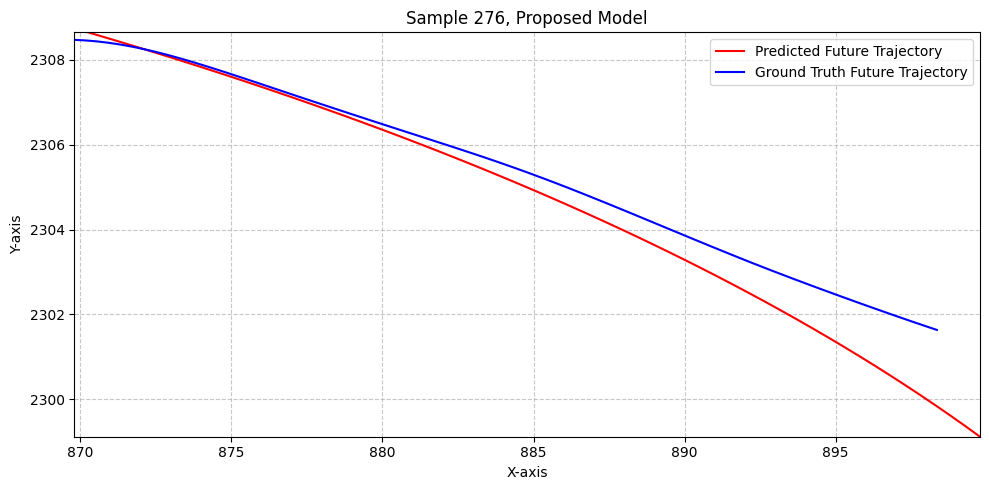

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [72]:
import matplotlib.pyplot as plt
import random
from google.colab import files

# Load model
model.load_state_dict(torch.load(best_models['first']['path']))
model.eval()

# Select one random sample from the validation set
#idx = random.choice(range(len(val_dataset)))
idx = 276
batch = val_dataset[idx]
batch = batch.to(device)

# Forward pass
pred = model(batch)

# Rescale and shift predictions to world coordinates
gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0)
pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
gt = gt * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)

# Convert to numpy
pred = pred.detach().cpu().numpy()
gt = gt.detach().cpu().numpy()

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
plot_trajectory(ax, pred, gt, title=f"Sample {idx}, Proposed Model")
plt.tight_layout()

# Save the plot
save_path = "trajectory_plot_imp.png"
plt.savefig(save_path)
plt.show()

# Downloard
files.download(save_path)


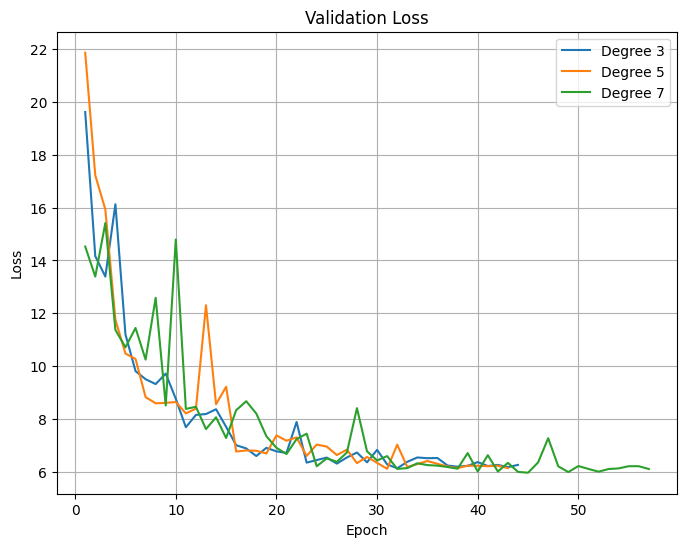

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
plt.figure(figsize=(8, 6))
from google.colab import files

# Plot each line with its own x-axis range
plt.plot(range(1, len(zero_heading_val) + 1), zero_heading_val, label='Degree 3')
plt.plot(range(1, len(degree_5_val) + 1), degree_5_val, label='Degree 5')
plt.plot(range(1, len(degree_7_val) + 1), degree_7_val, label='Degree 7')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('validation_loss_degree.png')
plt.show()

# Download the file
files.download('validation_loss_degree.png')


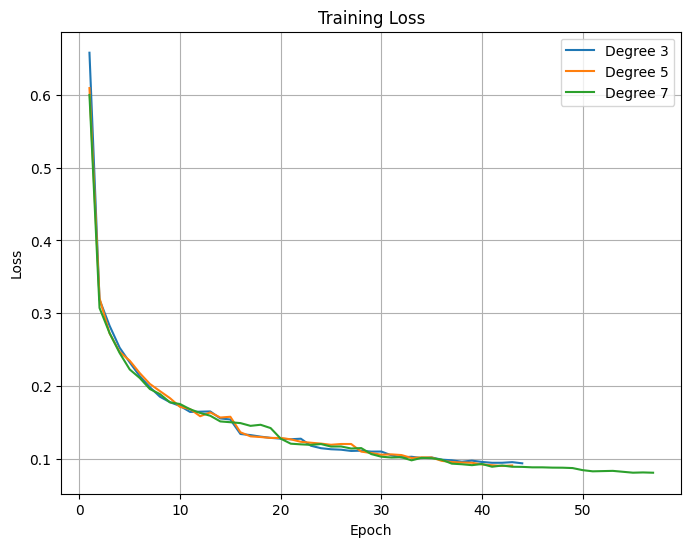

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
plt.figure(figsize=(8, 6))
from google.colab import files

# Plot each line with its own x-axis range
plt.plot(range(1, len(zero_heading_train) + 1), zero_heading_train, label='Degree 3')
plt.plot(range(1, len(degree_5_train) + 1), degree_5_train, label='Degree 5')
plt.plot(range(1, len(degree_7_train) + 1), degree_7_train, label='Degree 7')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)
plt.savefig('training_loss_degree.png')
plt.show()

# Download the file
files.download('training_loss_degree.png')

In [ ]:
import matplotlib.pyplot as plt
import random

def plot_trajectory(ax, pred, gt, title=None):
    ax.cla()
    # Plot the predicted future trajectory
    ax.plot(pred[0,:60,0], pred[0,:60,1], color='red', label='Predicted Future Trajectory')

    # Plot the ground truth future trajectory
    ax.plot(gt[0,:60,0], gt[0,:60,1], color='blue', label='Ground Truth Future Trajectory')

    # Optionally set axis limits, labels, and title.
    x_max = max(pred[..., 0].max(), gt[..., 0].max())
    x_min = min(pred[..., 0].min(), gt[..., 0].min())
    y_max = max(pred[..., 1].max(), gt[..., 1].max())
    y_min = min(pred[..., 1].min(), gt[..., 1].min())

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')

    if title:
        ax.set_title(title)

    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

In [ ]:
model.load_state_dict(torch.load(best_models['first']['path']))

<All keys matched successfully>

<ipython-input-35-68eb2f28bb17>:61: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future - origin


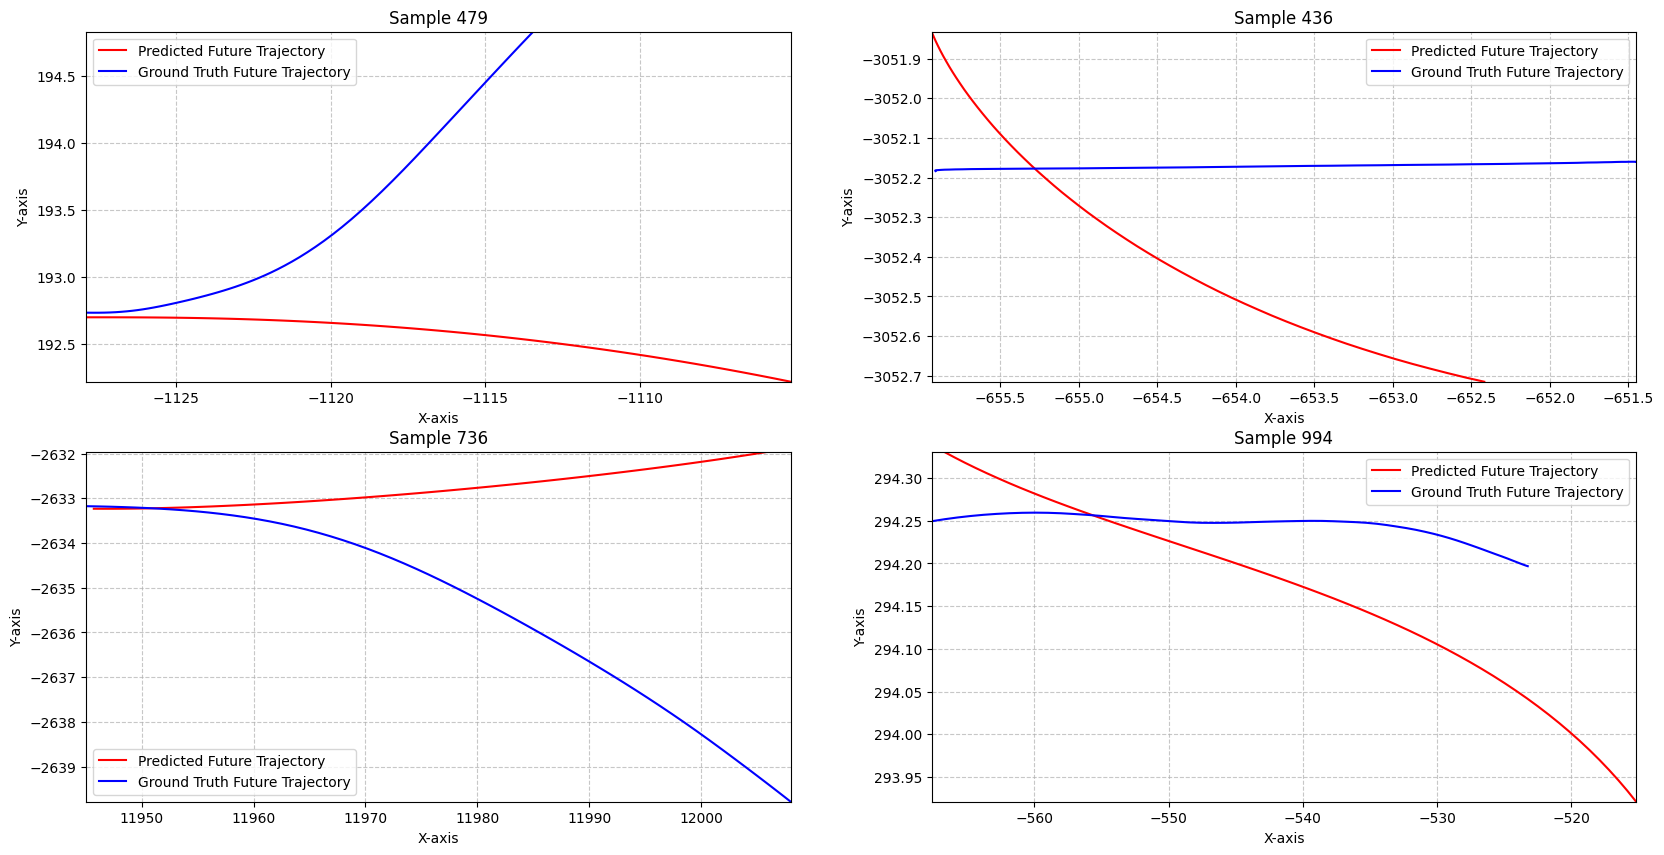

In [ ]:
#model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# randomly select 4 samples from the validation set
random_indices = random.sample(range(len(val_dataset)), 4)
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()  # Flatten the array to iterate single axes objects

for i, idx in enumerate(random_indices):
    batch = val_dataset[idx]
    batch = batch.to(device)
    pred = model(batch)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0)

    pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0) * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)

    pred = pred.detach().cpu().numpy()
    gt = gt.detach().cpu().numpy()

    # Plot the trajectory using the i-th axis
    plot_trajectory(axes[i], pred, gt, title=f"Sample {idx}")

plt.show()

#### Output your predictions of the best model on the test set

In [ ]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

#best_model = torch.load("best_model.pt")
#model = LinearRegressionModel().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
# model = LSTM().to(device)
#model = Agent0HybridTransformer(emb_dim=256,num_layers=6).to(device)
#model = Agent0TemporalAttentionTransformer(emb_dim=256, num_layers=6).to(device)
#model = Agent0TemporalAttentionTransformer(emb_dim=256, num_layers=8).to(device)

# Old best (second best submission):
#model = ImprovedLSTMParametricTrajectoryFeatures(degree=3, lstm_layers=2).to(device)

# Best so far:
#model = ImprovedLSTMParametricTrajectoryFeatures(degree=3, lstm_layers=2, other_rnn_dim=256).to(device)


model = ImprovedLSTMParametricTrajectoryFeatures(degree=3, lstm_layers=2, other_rnn_dim=256).to(device)


model.load_state_dict(torch.load(best_models['first']['path']))
#model.load_state_dict(best_model)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_norm = model(batch)  # prediction in ego frame (normalized)

        # Convert batch to list to access individual data elements
        data_list = batch.to_data_list()

        # Process each sample in the batch individually
        batch_predictions = []
        for i, data in enumerate(data_list):
            # Get the prediction for this sample
            single_pred_norm = pred_norm[i]  # Shape: (60, 2)

            # Step 1: Unnormalize (scale back up)
            single_pred = single_pred_norm * data.scale

            # Step 2: Translate back from origin (add back the translation)
            single_pred = single_pred + data.origin

            # Step 3: Rotate back to world coordinates
            # Since we applied @ R.T in preprocessing, we need to apply @ R to inverse
            R = data.rotation  # This is the rotation matrix R
            single_pred = single_pred @ R  # Apply inverse rotation

            batch_predictions.append(single_pred.cpu().numpy())

        # Stack predictions for this batch
        batch_pred_array = np.stack(batch_predictions, axis=0)
        pred_list.append(batch_pred_array)

# Concatenate all predictions
pred_list = np.concatenate(pred_list, axis=0)  # Shape: (N, 60, 2)

# Reshape for submission format
pred_output = pred_list.reshape(-1, 2)  # Shape: (N*60, 2)

# Create submission DataFrame
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission.csv', index=True)

In [ ]:
print(output_df.head(12))

                 x            y
index                          
0      5426.125977  1467.522583
1      5426.129883  1467.512817
2      5426.133301  1467.501587
3      5426.136719  1467.489014
4      5426.140137  1467.475098
5      5426.144043  1467.459839
6      5426.147949  1467.443359
7      5426.151855  1467.425659
8      5426.155762  1467.406738
9      5426.160156  1467.386719
10     5426.164551  1467.365479
11     5426.168457  1467.343018


In [ ]:
from google.colab import files
files.download('submission.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Step 4: Summarize your experiments and results in table and figures in the submitted PDF file for Question 3 Problem A

## Step 5: Analyze the results, identify the issues and plan for the improvement in the submitted PDF file for Question 3 Problem B